## Search and download ECOSTRESS temperature and evapotranspiration (ET) scenes
### Rocky Mountain National Park, Colorado

Add introduction here.

In [51]:
"""
Load the necessary packages and set environment variables
"""

# Import packages
import os
import folium
import earthaccess
import warnings
import folium.plugins
import pandas as pd
import geopandas as gpd
import rasterio as rio
import math

from branca.element import Figure
from IPython.display import display
from shapely import geometry
from skimage import io
from datetime import timedelta
from shapely.geometry.polygon import orient
from matplotlib import pyplot as plt

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:32613'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

# File path information
datadir = '/data-store/iplant/home/shared/esiil/HYR_SENSE/'

# File path information
print("Success")

Success


### Define some custom functions

These functions will be used throughout the remainder of the code. Feel free to read through each function to get an idea of what it does, but we will not cover these in great detail.

In [2]:
def get_shapely_object(result:earthaccess.results.DataGranule):
    """
    Retrieve geospatial information from ECOSTRESS granule footprints
    
    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    
    # Get Geometry Keys
    geo = result['umm']['SpatialExtent']['HorizontalSpatialDomain']['Geometry']
    keys = geo.keys()

    if 'BoundingRectangles' in keys:
        bounding_rectangle = geo['BoundingRectangles'][0]
        # Create bbox tuple
        bbox_coords = (bounding_rectangle['WestBoundingCoordinate'],bounding_rectangle['SouthBoundingCoordinate'],
                       bounding_rectangle['EastBoundingCoordinate'],bounding_rectangle['NorthBoundingCoordinate'])
        # Create shapely geometry from bbox
        shape = geometry.box(*bbox_coords, ccw=True)
    elif 'GPolygons' in keys:
        points = geo['GPolygons'][0]['Boundary']['Points']
        # Create shapely geometry from polygons
        shape = geometry.Polygon([[p['Longitude'],p['Latitude']] for p in points])
    else:
         raise ValueError('Provided result does not contain bounding boxes/polygons or is incompatible.')
    return(shape)

# Retrieve png browse image if it exists or first jpg in list of urls
def get_png(result:earthaccess.results.DataGranule):
    """
    Retrieve the browse image from the search results
    This browse image can be used to display the granule quickly and effectively before downloading

    :param 'result:earthaccess.results.DataGranule': a single data granule from earthaccess data search
    """
    https_links = [link for link in result.dataviz_links() if 'https' in link]
    if len(https_links) == 1:
        browse = https_links[0]
    elif len(https_links) == 0:
        browse = 'no browse image'
        warnings.warn(f"There is no browse imagery for {result['umm']['GranuleUR']}.")
    else:
        browse = [png for png in https_links if '.png' in png][0]
    return(browse)

# Convert bounding coordinates to Folium-ready data for mapping
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))
    
print("Ready")

Ready


### Prep the data

In [ ]:
# Optional (?) shutil copyTree files over to a temporary local folder

import shutil

dest = ''

### Import the project data

Before we begin, let's grab some existing data from the CyVerse "data store". We'll grab a study area polygon which we'll use to search for ECOSTRESS scenes.

... Background for region of interest

Map of Rocky Mountain National Park (RMNP) with intersecting fire protection districts ~

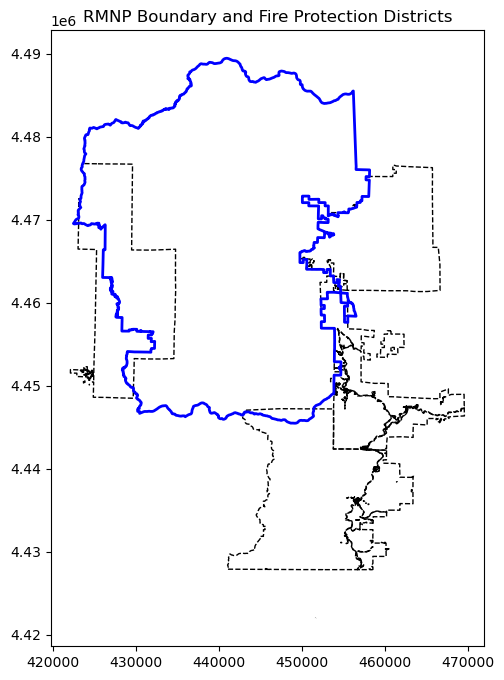

In [6]:
# Read in the RMNP boundary as a GeoJSON using the Python package GeoPandas
romo = gpd.read_file(os.path.join(datadir, 'data/Drought-FireRisk/NPS_ROMO_Boundary.geojson'))
romo = romo.to_crs(prj) # project CRS

# Also bring in the Colorado Fire Protection Districts and intersect with the RMNP boundary
fpd = gpd.read_file(os.path.join(datadir, 'data/Drought-FireRisk/CO_Fire_Protection_Districts.geojson'))
fpd = fpd.to_crs(prj) # make sure the projections match
fpd_romo = fpd[fpd.intersects(romo.unary_union)] # Perform the spatial intersection

# Create a map of RMNP and adjacent FPD
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
# Plot the intersecting Fire Protection Districts
fpd_romo.plot(ax=ax, color='none', edgecolor='black', linewidth=1, linestyle='--', label='Intersecting Districts')
# Plot the RMNP boundary
romo.plot(ax=ax, color='none', edgecolor='blue', linewidth=2, label='RMNP Boundary')
# Add legend and title
plt.title('RMNP Boundary and Fire Protection Districts')
plt.show()

## ECOSTRESS: 
#### - Land Surface Temperature and Emissivity Daily L2 Global 70 m
#### - Evapotranspiration PT-JPL Daily L3 Global 70 m

We can use the "earthaccess" Python package to find relevant datasets associated with the ECOSTRESS mission. In particular, we will use the ECOSTRESS Land Surface Temperature and Emissivity Daily L2 70-m product ("ECO_L2T_LSTE") and the daily evapotranspiration L3 70-m product (). With earthaccess, we can search for and print all of the available data sets. Using this capability, we can also search for a specific data product by its "short name". 

To learn more about the ECOSTRESS LSTE: https://lpdaac.usgs.gov/products/eco2lstev001/
To learn more about the ECOSTRESS Evapotranspiration: https://lpdaac.usgs.gov/products/eco3etptjplv001/


In [10]:
## Query the collections for ECOSTRESS
Query = earthaccess.collection_query().keyword('ECOSTRESS').provider('LPCLOUD')
print(f'Collections found: {Query.hits()}')

# Return search results as a list
collections = Query.fields(['ShortName']).get(Query.hits())

# Retrieve Collection short-names
print("All available data products: ")
[product['short-name'] for product in [collection.summary() for collection in collections]]

# Filter for our products of interest


Collections found: 23
Available data products: 


['ECO_L4G_ESI',
 'ECO_L4G_WUE',
 'ECO_L4T_ESI',
 'ECO_L4T_WUE',
 'ECO_L3G_JET',
 'ECO_L3G_MET',
 'ECO_L3G_SEB',
 'ECO_L3G_SM',
 'ECO_L3T_JET',
 'ECO_L3T_MET',
 'ECO_L3T_SEB',
 'ECO_L3T_SM',
 'ECO_L2G_CLOUD',
 'ECO_L2G_LSTE',
 'ECO_L2T_LSTE',
 'ECO_L2T_STARS',
 'ECO_L2_CLOUD',
 'ECO_L2_LSTE',
 'ECO_L1B_ATT',
 'ECO_L1B_GEO',
 'ECO_L1B_RAD',
 'ECO_L1CG_RAD',
 'ECO_L1CT_RAD']

In [ ]:
# # (OPTIONAL) 
# # If you are using a Shapefile or GeoPackage you need to retrieve the coordinate pairs

# # ~ Extract a list coordinate pairs for ROI ~

# # First, reproject to WGS84 for coordinates are in degrees
# roi = roi.to_crs(epsg=4326)

# # Extract the bounds
# coord_list = []
# for iter, row in roi.iterrows():
#     bounds = row['geometry'].bounds
#     coord_list.append(bounds)
# print(coord_list)
# if len(coord_list) == 1:
#     coord_list = coord_list[0]
# else:
#     coord_list = coord_list

In [60]:
# Define some search parameters
short_names = ['ECO_L2G_LSTE', 'ECO_L4_ESI'] # note that there are many more granules for 'ECO_L2_LSTE' or 'ECO_L2G_LSTE'
date_ranges = [('2022-05-01','2022-06-30'),('2022-09-01','2022-10-31')]
seasons = ['Spring','Fall']

# Retrieve the coordinate pairs for the region of interest
romo = romo.to_crs(geog) # convert back to geographic coordinates
geom = romo.unary_union.envelope # dissolve into a single shape and get the envelope
coords = list(geom.exterior.coords) # retrieve the coordinate pairs

results = {}
for short_name in short_names:
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(f"Data product: {short_name}")
    i=0
    season_results = []
    for date_range in date_ranges:
        season = seasons[i]
        print(f"Season: {season}; Date range: {date_range}")
    
        # Search for ECOSTRESS products matching our short names
        result = earthaccess.search_data(
            short_name=short_name,
            polygon=coords,
            temporal=date_range,
            count=500, 
        )
    
        # Save the results as a data frame, append to dictionary
        df = pd.json_normalize(result)
        df['season'] = season

        # Create shapely polygons for result
        geometries = [get_shapely_object(result[index]) for index in df.index.to_list()]
        # Convert to GeoDataframe
        results_gdf = gpd.GeoDataFrame(df, geometry=geometries, crs="EPSG:4326")
        # Add browse imagery links
        # results_gdf['browse'] = [get_png(granule) for granule in result]
        results_gdf['shortname'] = [r['umm']['CollectionReference']['ShortName'] for r in result]
        # Add data links which can be used to download the granules later
        results_gdf['data_link'] = [
            feature['umm']['RelatedUrls'][0]['URL'] if 'RelatedUrls' in feature['umm'] and len(feature['umm']['RelatedUrls']) > 0 
            else None for feature in result]
        
        season_results.append(results_gdf)
        
        i=i+1

    # Merge the results for both seasons
    season_results = pd.concat(season_results)
    
    results[short_name] = season_results

~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO_L2G_LSTE
Season: Spring; Date range: ('2022-05-01', '2022-06-30')
Granules found: 60
Season: Fall; Date range: ('2022-09-01', '2022-10-31')
Granules found: 39
~~~~~~~~~~~~~~~~~~~~~~~~~~~
Data product: ECO_L4_ESI
Season: Spring; Date range: ('2022-05-01', '2022-06-30')
Granules found: 0
Season: Fall; Date range: ('2022-09-01', '2022-10-31')
Granules found: 0


In [61]:
# For now just work with the LST
results_gdf = results['ECO_L2G_LSTE']
print(results_gdf.columns)

# Preview GeoDataframe
print(f'{results_gdf.shape[0]} granules total')

Index(['size', 'meta.concept-type', 'meta.concept-id', 'meta.revision-id',
       'meta.native-id', 'meta.collection-concept-id', 'meta.provider-id',
       'meta.format', 'meta.revision-date',
       'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
       'umm.TemporalExtent.RangeDateTime.EndingDateTime',
       'umm.OrbitCalculatedSpatialDomains', 'umm.GranuleUR',
       'umm.AdditionalAttributes', 'umm.MeasuredParameters',
       'umm.SpatialExtent.HorizontalSpatialDomain.Geometry.BoundingRectangles',
       'umm.ProviderDates', 'umm.CollectionReference.ShortName',
       'umm.CollectionReference.Version', 'umm.PGEVersionClass.PGEVersion',
       'umm.RelatedUrls', 'umm.DataGranule.DayNightFlag',
       'umm.DataGranule.Identifiers', 'umm.DataGranule.ProductionDateTime',
       'umm.DataGranule.ArchiveAndDistributionInformation', 'umm.Platforms',
       'umm.MetadataSpecification.URL', 'umm.MetadataSpecification.Name',
       'umm.MetadataSpecification.Version', 'season', 'geom

In [62]:
# # Create a list of columns to keep
# keep_cols = ['season','meta.concept-id','meta.native-id', 
#              'umm.TemporalExtent.RangeDateTime.BeginningDateTime',
#              'umm.TemporalExtent.RangeDateTime.EndingDateTime',
#              'umm.CloudCover','umm.DataGranule.DayNightFlag', 'umm.GranuleUR',
#              'geometry','browse', 'shortname', 'data_link']
# # Remove unneeded columns
# results_gdf = results_gdf.loc[:, results_gdf.columns.intersection(keep_cols)]

results_gdf.rename(
    columns = {'meta.concept-id':'concept_id','meta.native-id':'granule',
               'umm.TemporalExtent.RangeDateTime.BeginningDateTime':'start_datetime',
               'umm.TemporalExtent.RangeDateTime.EndingDateTime':'end_datetime',
               'umm.CloudCover':'cloud_cover',
               'umm.GranuleUR':'granule_id',
               'umm.DataGranule.DayNightFlag':'day_night',
              }, inplace=True)
results_gdf['datetime_obj'] = pd.to_datetime(results_gdf['start_datetime']) # 2i2c
results_gdf.head()

,size,meta.concept-type,concept_id,meta.revision-id,granule,meta.collection-concept-id,meta.provider-id,meta.format,meta.revision-date,start_datetime,...,umm.DataGranule.ArchiveAndDistributionInformation,umm.Platforms,umm.MetadataSpecification.URL,umm.MetadataSpecification.Name,umm.MetadataSpecification.Version,season,geometry,shortname,data_link,datetime_obj
0,301.900,granule,G2269630938-LPCLOUD,1,ECOv002_L2G_LSTE_21649_006_20220501T090610_070...,C2076113037-LPCLOUD,LPCLOUD,application/echo10+xml,2022-05-12T19:03:46.353Z,2022-05-01T09:06:11.210Z,...,"[{'Name': 'Not provided', 'Size': 301.9, 'Size...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,Spring,"POLYGON ((-105.54000 36.10380, -105.54000 41.0...",ECO_L2G_LSTE,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2022-05-01 09:06:11.210000+00:00
1,303.900,granule,G2269630410-LPCLOUD,1,ECOv002_L2G_LSTE_21649_007_20220501T090702_070...,C2076113037-LPCLOUD,LPCLOUD,application/echo10+xml,2022-05-12T19:01:53.440Z,2022-05-01T09:07:03.180Z,...,"[{'Name': 'Not provided', 'Size': 303.9, 'Size...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,Spring,"POLYGON ((-102.18780 38.11620, -102.18780 43.0...",ECO_L2G_LSTE,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2022-05-01 09:07:03.180000+00:00
2,308.450,granule,G2269713427-LPCLOUD,1,ECOv002_L2G_LSTE_21653_007_20220501T153609_070...,C2076113037-LPCLOUD,LPCLOUD,application/echo10+xml,2022-05-13T01:03:44.651Z,2022-05-01T15:36:10.300Z,...,"[{'Name': 'Not provided', 'Size': 308.45, 'Siz...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,Spring,"POLYGON ((-105.59160 37.80060, -105.59160 43.0...",ECO_L2G_LSTE,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2022-05-01 15:36:10.300000+00:00
3,296.150,granule,G2269631569-LPCLOUD,1,ECOv002_L2G_LSTE_21653_008_20220501T153701_070...,C2076113037-LPCLOUD,LPCLOUD,application/echo10+xml,2022-05-12T19:05:42.234Z,2022-05-01T15:37:02.270Z,...,"[{'Name': 'Not provided', 'Size': 296.15, 'Siz...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,Spring,"POLYGON ((-102.39540 35.77200, -102.39540 40.9...",ECO_L2G_LSTE,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2022-05-01 15:37:02.270000+00:00
4,291.659,granule,G2274796773-LPCLOUD,1,ECOv002_L2G_LSTE_21664_007_20220502T081835_070...,C2076113037-LPCLOUD,LPCLOUD,application/echo10+xml,2022-05-19T15:11:03.437Z,2022-05-02T08:18:35.740Z,...,"[{'Name': 'Not provided', 'Size': 291.659, 'Si...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,Spring,"POLYGON ((-100.68180 35.31180, -100.68180 40.2...",ECO_L2G_LSTE,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,2022-05-02 08:18:35.740000+00:00


In [63]:
# Create Figure and Select Background Tiles

fig = Figure(width="750px", height="375px")
map1 = folium.Map(tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', attr='Google')
fig.add_child(map1)

# Plot Region of Interest
romo.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="Region of Interest",
    m=map1
)

results_gdf.drop(columns=['datetime_obj']).explore(
    "granule",
    categorical=True,
    tooltip=[
        "granule",
        "start_datetime",
    ],
    popup=True,
    style_kwds=dict(fillOpacity=0.1, width=2),
    name="ECOSTRESS",
    m=map1,
    legend=False
)

map1.fit_bounds(bounds=convert_bounds(results_gdf.unary_union.bounds))
map1.add_child(folium.LayerControl())
display(fig)

### Analyzing the ECOSTRESS data in the cloud

We now have a list of ECOSTRESS granules for our study region. We can now leverage the capabilities for analyzing data in the cloud using the ECOSTRESS Cloud-optimized GeoTiff (COG) formats. ... more info here ...

For example, we can create a median LSTE composite for RMNP for Spring and Fall.

In [64]:
print(results_gdf['season'].unique())

['Spring' 'Fall']


In [65]:
print(results_gdf['data_link'][0])

cog_urls = results_gdf['data_link'][0]

# Stream and process the data
for cog_url in cog_urls:
    with rio.open(cog_url) as src:
        # Read the entire COG
        array = src.read(1)  # Reading the first band

        # Process the array (e.g., calculate statistics or apply filters)
        mean_temp = np.mean(array)
        print(f"Mean temperature for granule: {mean_temp}")

        # Optionally, visualize the data
        plt.imshow(array, cmap='hot')
        plt.colorbar()
        plt.title("ECOSTRESS Land Surface Temperature")
        plt.show()

0    https://data.lpdaac.earthdatacloud.nasa.gov/lp...
0    https://data.lpdaac.earthdatacloud.nasa.gov/lp...
Name: data_link, dtype: object


RasterioIOError: '/vsicurl/https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2G_LSTE.002/ECOv002_L2G_LSTE_21649_006_20220501T090610_0700_01/ECOv002_L2G_LSTE_21649_006_20220501T090610_0700_01.h5' not recognized as a supported file format.